<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://bsethwalker.github.io/assets/img/clemson_paw.png"> </div>

## Week 4: Regressions

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>
**Author(s):** Chris Kalahiki, Brandon Walker


---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://bsethwalker.github.io/assets/css/cpsc6300.css").text
HTML(styles)

## Learning Goals

By the end of this lab, you should be able to:
* Feel comfortable with simple linear regression
* Feel comfortable with polynomial regression
* Feel comfortable with multiple linear regression

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

import warnings

<a class="anchor" id="third-bullet"></a>
## 1 - Simple Linear Regression

Linear regression and its many extensions are a workhorse of the statistics and data science community, both in application and as a reference point for other models. Most of the major concepts in machine learning can be and often are discussed in terms of various linear regression models. Thus, this section will introduce you to building and fitting linear regression models and some of the process behind it, so that you can 1) fit models to data you encounter 2) experiment with different kinds of linear regression and observe their effects 3) see some of the technology that makes regression models work.


### Linear regression with a toy dataset
We first examine a toy problem, focusing our efforts on fitting a linear model to a small dataset with three observations.  Each observation consists of one predictor $x_i$ and one response $y_i$ for $i = 1, 2, 3$,

\begin{align*}
(x , y) = \{(x_1, y_1), (x_2, y_2), (x_3, y_3)\}.
\end{align*}

To be very concrete, let's set the values of the predictors and responses.

\begin{equation*}
(x , y) = \{(1, 2), (2, 2), (3, 4)\}
\end{equation*}

There is no line of the form $\beta_0 + \beta_1 x = y$ that passes through all three observations, since the data are not collinear. Thus our aim is to find the line that best fits these observations in the *least-squares sense*, as discussed in lecture.

<div class="exercise"><b>Exercise</b></div>

* Make two numpy arrays out of this data, x_train and y_train
* Check the dimentions of these arrays
* Try to reshape them into a different shape
* Make points into a very simple scatterplot


In [3]:
# solution
x_train = np.array([1,2,3])
y_train = np.array([2,2,4])
type(x_train)

numpy.ndarray

In [4]:
# Check the dimentions of these arrays
print(x_train.shape)
print(y_train.shape)

(3,)
(3,)


In [5]:
# Try to reshape them into a different shape
print(np.reshape(x_train,(1,3)).shape)
print(np.reshape(y_train,(1,3)).shape)

(1, 3)
(1, 3)


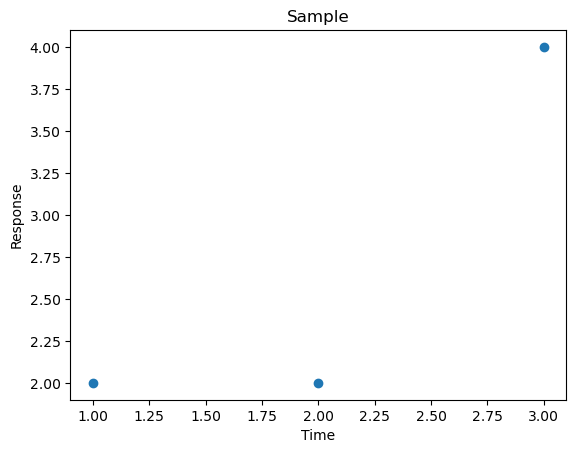

In [6]:
# Make a simple scatterplot using the initial x_train, y_train numpy arrays
plt.scatter(x_train,y_train)
plt.title("Sample")
plt.xlabel("Time")
plt.ylabel("Response")
plt.show()



<div class="exercise"><b>Nice Scatterplot</b></div>

<AxesSubplot:title={'center':'hello nice plot'}, xlabel='$x$', ylabel='$y$'>

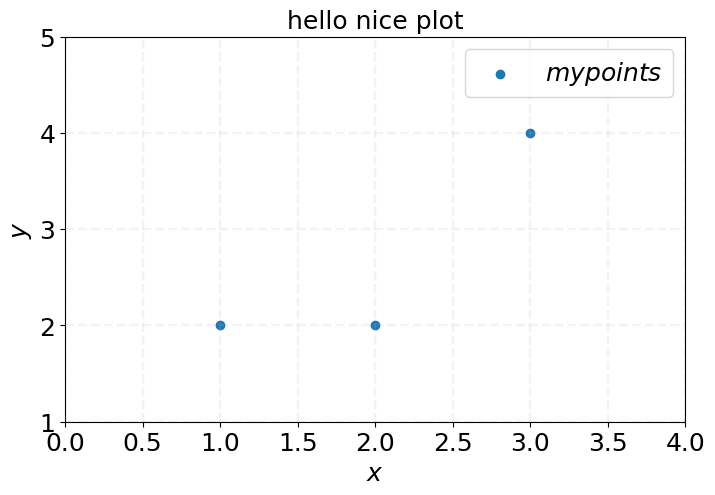

In [7]:
def nice_scatterplot(x, y, title):
    # font size
    f_size = 18
    
    # make the figure
    fig, ax = plt.subplots(1,1, figsize=(8,5)) # Create figure object

    # set axes limits to make the scale nice
    ax.set_xlim(np.min(x)-1, np.max(x) + 1)
    ax.set_ylim(np.min(y)-1, np.max(y) + 1)

    # adjust size of tickmarks in axes
    ax.tick_params(labelsize = f_size)
    
    # remove tick labels
    #ax.tick_params(labelbottom=False, bottom=False)
    
    # adjust size of axis label
    ax.set_xlabel(r'$x$', fontsize = f_size)
    ax.set_ylabel(r'$y$', fontsize = f_size)
    
    # set figure title label
    ax.set_title(title, fontsize = f_size)

    # you may set up grid with this 
    ax.grid(True, lw=1.75, ls='--', alpha=0.15)

    # make actual plot (Notice the label argument!)
    ax.scatter(x, y, label=r'$my points$')
    ax.legend(loc='best', fontsize = f_size)
    
    return ax

nice_scatterplot(x_train, y_train, 'hello nice plot')


#### Formulae
Linear regression is special among the models we study because it can be solved explicitly. While most other models (and even some advanced versions of linear regression) must be solved itteratively, linear regression has a formula where you can simply plug in the data.

For the single predictor case it is:
$\beta_1 = \frac{\sum_{i=1}^n{(x_i-\bar{x})(y_i-\bar{y})}}{\sum_{i=1^n{(x_i-\bar{x})^2}}\beta_0 = \bar{y} - \beta_1\bar{x}}$
    
Where $\bar{y}$ and $\bar{x}$ are the mean of the y values and the mean of the x values, respectively.

###  Building a model from scratch
In this part, we will solve the equations for simple linear regression and find the best fit solution to our toy problem.

The snippets of code below implement the linear regression equations on the observed predictors and responses, which we'll call the training data set.  Let's walk through the code.

We have to reshape our arrrays to 2D. We will see later why.

<div class="exercise"><b>Exercise</b></div>

* make an array with shape (2,3)
* reshape it to a size that you want

In [8]:
#your code here
ex_array = np.array([[0,0,0],[1,1,1]])
print(ex_array.shape)

(2, 3)


In [9]:
# Reshape to be a proper 2D array
x_train = x_train.reshape(x_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

print(x_train.shape)

(3, 1)


In [10]:
# first, compute means
y_bar = np.mean(y_train)
x_bar = np.mean(x_train)

# build the two terms
numerator = np.sum( (x_train - x_bar)*(y_train - y_bar) )
denominator = np.sum((x_train - x_bar)**2)

print(numerator.shape, denominator.shape) #check shapes

() ()


* Why the empty brackets? (The numerator and denominator are scalars, as expected.)

In [11]:
#slope beta1
beta_1 = numerator/denominator

#intercept beta0
beta_0 = y_bar - beta_1*x_bar

print("The best-fit line is {0:3.2f} + {1:3.2f} * x".format(beta_0, beta_1))
print(f'The best fit is {beta_0}')

The best-fit line is 0.67 + 1.00 * x
The best fit is 0.6666666666666665


Turn the code from the above cells into a function called `simple_linear_regression_fit`, that inputs the training data and returns `beta0` and `beta1`.

To do this, copy and paste the code from the above cells below and adjust the code as needed, so that the training data becomes the input and the betas become the output.

```python
def simple_linear_regression_fit(x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    
    return
```

Check your function by calling it with the training data from above and printing out the beta values.

In [12]:
def simple_linear_regression_fit(x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    """
    Inputs:
    x_train: a (num observations by 1) array holding the values of the predictor variable
    y_train: a (num observations by 1) array holding the values of the response variable

    Returns:
    beta_vals:  a (num_features by 1) array holding the intercept and slope coeficients
    """
    
    # Check input array sizes
    if len(x_train.shape) < 2:
        print("Reshaping features array.")
        x_train = x_train.reshape(x_train.shape[0], 1)

    if len(y_train.shape) < 2:
        print("Reshaping observations array.")
        y_train = y_train.reshape(y_train.shape[0], 1)

    # first, compute means
    y_bar = np.mean(y_train)
    x_bar = np.mean(x_train)

    # build the two terms
    numerator = np.sum( (x_train - x_bar)*(y_train - y_bar) )
    denominator = np.sum((x_train - x_bar)**2)
    
    #slope beta1
    beta_1 = numerator/denominator

    #intercept beta0
    beta_0 = y_bar - beta_1*x_bar

    return np.array([beta_0,beta_1])


* Let's run this function and see the coefficients

In [13]:
x_train = np.array([1 ,2, 3])
y_train = np.array([2, 2, 4])

betas = simple_linear_regression_fit(x_train, y_train)

beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:8.6f} + {1:8.6f} * x".format(beta_0, beta_1))

Reshaping features array.
Reshaping observations array.
The best-fit line is 0.666667 + 1.000000 * x


<div class="exercise"><b>Exercise</b></div>

* Do the values of `beta0` and `beta1` seem reasonable?
* Plot the training data using a scatter plot.
* Plot the best fit line with `beta0` and `beta1` together with the training data.

Text(0, 0.5, '$y$')

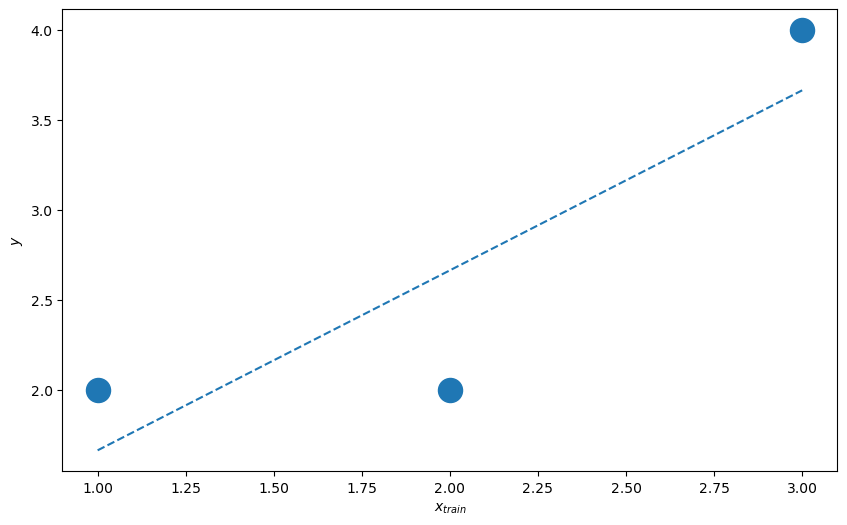

In [14]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

x_train = np.array([[1, 2, 3]]).T

best_fit = beta_0 + beta_1 * x_train

ax_scat.scatter(x_train, y_train, s=300, label='Training Data')
ax_scat.plot(x_train, best_fit, ls='--', label='Best Fit Line')

ax_scat.set_xlabel(r'$x_{train}$')
ax_scat.set_ylabel(r'$y$')

<a class="anchor" id="fourth-bullet"></a>
## 3 - Building a model with `statsmodels` and `sklearn`

Now that we can concretely fit the training data from scratch, let's learn two `python` packages to do it all for us:
* [statsmodels](http://www.statsmodels.org/stable/regression.html) and 
* [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Our goal  is to show how to implement simple linear regression with these packages.  For an important sanity check, we compare the $\beta$ values from `statsmodels` and `sklearn` to the $\beta$ values that we found from above with our own implementation.

For the purposes of this lab, `statsmodels` and `sklearn` do the same thing.  More generally though, `statsmodels` tends to be easier for inference \[finding the values of the slope and intercept and dicussing uncertainty in those values\], whereas `sklearn` has machine-learning algorithms and is better for prediction \[guessing y values for a given x value\]. (Note that both packages make the same guesses, it's just a question of which activity they provide more support for.

**Note:** `statsmodels` and `sklearn` are different packages!  Unless we specify otherwise, you can use either one.

Below is the code for `statsmodels`.  `Statsmodels` does not by default include the column of ones in the $X$ matrix, so we include it manually with `sm.add_constant`.

In [15]:
# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(x_train)

# this is the same matrix as in our scratch problem!
print(X)

# build the OLS model (ordinary least squares) from the training data
toyregr_sm = sm.OLS(y_train, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = toyregr_sm.fit()

# pull the beta parameters out from results_sm
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print(f'The regression coef from statsmodels are: beta_0 = {beta0_sm:8.6f} and beta_1 = {beta1_sm:8.6f}')

[[1. 1.]
 [1. 2.]
 [1. 3.]]
The regression coef from statsmodels are: beta_0 = 0.666667 and beta_1 = 1.000000


Besides the beta parameters, `results_sm` contains a ton of other potentially useful information.

In [16]:
warnings.filterwarnings('ignore')
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3.000
Date:                Tue, 27 Sep 2022   Prob (F-statistic):              0.333
Time:                        22:49:16   Log-Likelihood:                -2.0007
No. Observations:                   3   AIC:                             8.001
Df Residuals:                       1   BIC:                             6.199
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667      1.247      0.535      0.6

Now let's turn our attention to the `sklearn` library.

# build the least squares model
toyregr = linear_model.LinearRegression()

# save regression info (parameters, etc) in results_skl
results = toyregr.fit(x_train, y_train)

# pull the beta parameters out from results_skl
beta0_skl = toyregr.intercept_
beta1_skl = toyregr.coef_[0]

print("The regression coefficients from the sklearn package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_skl, beta1_skl))

### The `scikit-learn` library and the shape of things

Before diving into a "real" problem, let's discuss more of the details of `sklearn`.

`Scikit-learn` is the main `Python` machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split()`. 

Use the following to add the library into your code:

```python
import sklearn 
```

In `scikit-learn`, an **estimator** is a Python object that implements the methods `fit(X, y)` and `predict(T)`

Let's see the structure of `scikit-learn` needed to make these fits. `fit()` always takes two arguments:
```python
estimator.fit(Xtrain, ytrain)
```
We will consider two estimators in this lab: `LinearRegression` and `KNeighborsRegressor`.

It is very important to understand that `Xtrain` must be in the form of a **2x2 array** with each row corresponding to one sample, and each column corresponding to the feature values for that sample.

`ytrain` on the other hand is a simple array of responses.  These are continuous for regression problems.

### Practice with `sklearn` and a real dataset
We begin by loading up the `mtcars` dataset. This data was extracted from the 1974 Motor Trend US magazine, and comprises of fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models). We will load this data to a dataframe with 32 observations on 11 (numeric) variables. Here is an explanation of the features:

- `mpg` is Miles/(US) gallon 
- `cyl` is Number of cylinders, 
- `disp` is	Displacement (cu.in.), 
- `hp` is	Gross horsepower, 
- `drat` is	Rear axle ratio, 
- `wt` is the Weight (1000 lbs), 
- `qsec` is 1/4 mile time,
- `vs` is Engine (0 = V-shaped, 1 = straight), 
- `am` is Transmission (0 = automatic, 1 = manual), 
- `gear` is the Number of forward gears, 
- `carb` is	Number of carburetors.

In [17]:
#load mtcars
dfcars = pd.read_csv("mtcars.csv")
dfcars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [18]:
# Fix the column title 
dfcars = dfcars.rename(columns={"Unnamed: 0":"car name"})
dfcars.head()

,car name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [19]:
dfcars.shape

(32, 12)

#### Searching for values: how many cars have 4 gears?

len(dfcars[dfcars.gear == 4].drop_duplicates(subset='car name', keep='first'))

Next, let's split the dataset into a training set and test set.

In [20]:
#set random_state to get the same split every time
traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

In [21]:
# testing set is around 20% of the total data; training set is around 80%
print("Shape of full dataset is: {0}".format(dfcars.shape))
print("Shape of training dataset is: {0}".format(traindf.shape))
print("Shape of test dataset is: {0}".format(testdf.shape))

Shape of full dataset is: (32, 12)
Shape of training dataset is: (25, 12)
Shape of test dataset is: (7, 12)


Now we have training and test data.  We still need to select a predictor and a response from this dataset.  Keep in mind that we need to choose the predictor and response from both the training and test set.  You will do this in the exercises below.  However, we provide some starter code for you to get things going.

In [22]:
traindf.head()

,car name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
25,Fiat X1-9,27.3,4,79.0,66,4.08,1.935,18.90,1,1,4,1
12,Merc 450SL,17.3,8,275.8,180,3.07,3.730,17.60,0,0,3,3
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
16,Chrysler Imperial,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4


In [23]:
# Extract the response variable that we're interested in
y_train = traindf.mpg
y_train

25    27.3
12    17.3
0     21.0
4     18.7
16    14.7
5     18.1
13    15.2
11    16.4
23    13.3
1     21.0
2     22.8
26    26.0
3     21.4
21    15.5
27    30.4
22    15.2
18    30.4
31    21.4
20    21.5
7     24.4
10    17.8
14    10.4
28    15.8
19    33.9
6     14.3
Name: mpg, dtype: float64

Now, notice the shape of `y_train`.

In [24]:
y_train.shape, type(y_train)

((25,), pandas.core.series.Series)

### Array reshape
This is a 1D array as should be the case with the **Y** array.  Remember, `sklearn` requires a 2D array only for the predictor array.  You will have to pay close attention to this in the exercises later. `Sklearn` doesn't care too much about the shape of `y_train`.

The whole reason we went through that whole process was to show you how to reshape your data into the correct format.

**IMPORTANT:** Remember that your response variable `ytrain` can be a vector but your predictor variable `xtrain` ***must*** be an array!

<a class="anchor" id="fifth-bullet"></a>
## 3 - Example: Simple linear regression with automobile data
We will now use `sklearn` to predict automobile mileage per gallon (mpg) and evaluate these predictions. We already loaded the data and split them into a training set and a test set.

We need to choose the variables that we think will be good predictors for the dependent variable `mpg`. 

<div class="exercise"><b>Exercise</b></div>

* Pick one variable to use as a predictor for simple linear regression.  Discuss your reasons with the person next to you.  
* Justify your choice with some visualizations.  
* Is there a second variable you'd like to use? For example, we're not doing multiple linear regression here, but if we were, is there another variable you'd like to include if we were using two predictors?

Text(0, 0.5, 'Car MPG')

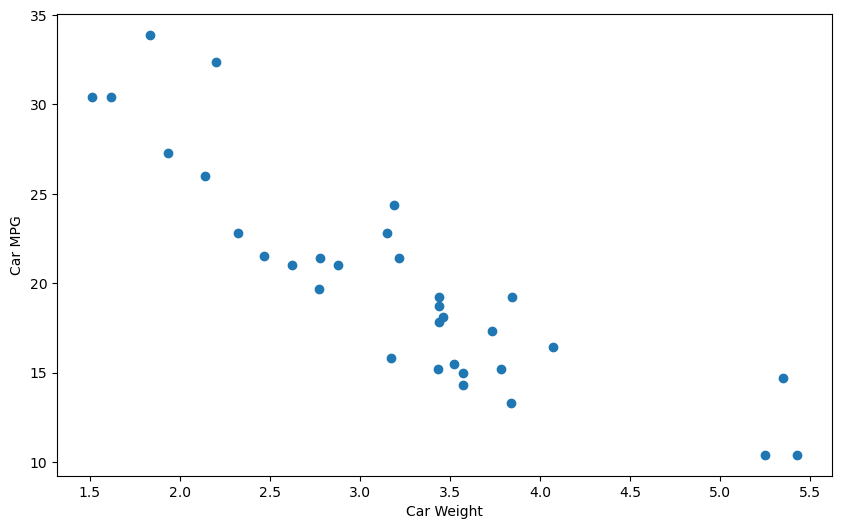

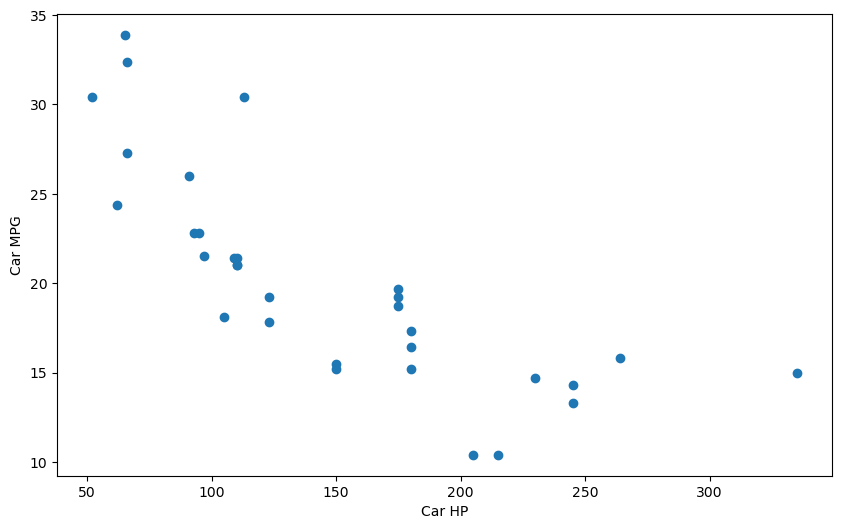

In [25]:
y_mpg = dfcars.mpg
x_wt = dfcars.wt
x_hp = dfcars.hp

fig_wt, ax_wt = plt.subplots(1,1, figsize=(10,6))
ax_wt.scatter(x_wt, y_mpg)
ax_wt.set_xlabel(r'Car Weight')
ax_wt.set_ylabel(r'Car MPG')

fig_hp, ax_hp = plt.subplots(1,1, figsize=(10,6))
ax_hp.scatter(x_hp, y_mpg)
ax_hp.set_xlabel(r'Car HP')
ax_hp.set_ylabel(r'Car MPG')

* Use `sklearn` to fit the training data using simple linear regression.
* Use the model to make mpg predictions on the test set.  
* Plot the data and the prediction.  
* Print out the mean squared error for the training set and the test set and compare.

In [26]:
dfcars = pd.read_csv('mtcars.csv')
dfcars = dfcars.rename(columns={"Unnamed: 0":"name"})

dfcars.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [27]:
traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

y_train = np.array(traindf.mpg)
X_train = np.array(traindf.wt)
X_train = X_train.reshape(X_train.shape[0], 1)

In [28]:
y_test = np.array(testdf.mpg)
X_test = np.array(testdf.wt)
X_test = X_test.reshape(X_test.shape[0], 1)

In [29]:
# Let's take another look at our data
dfcars.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [30]:
# And out train and test sets 
y_train.shape, X_train.shape

((25,), (25, 1))

In [31]:
y_test.shape, X_test.shape

((7,), (7, 1))

In [32]:
#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(f'R^2 = {r2:.5}')

R^2 = 0.68798


In [33]:
print(regression.score(X_train, y_train))

print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(X_train)))

print('Coefficients: \n', regression.coef_[0], regression.intercept_)

0.7701379909791617
12.475985659918825
7.773697766387515
Coefficients: 
 -5.33694140055708 36.93731031351841


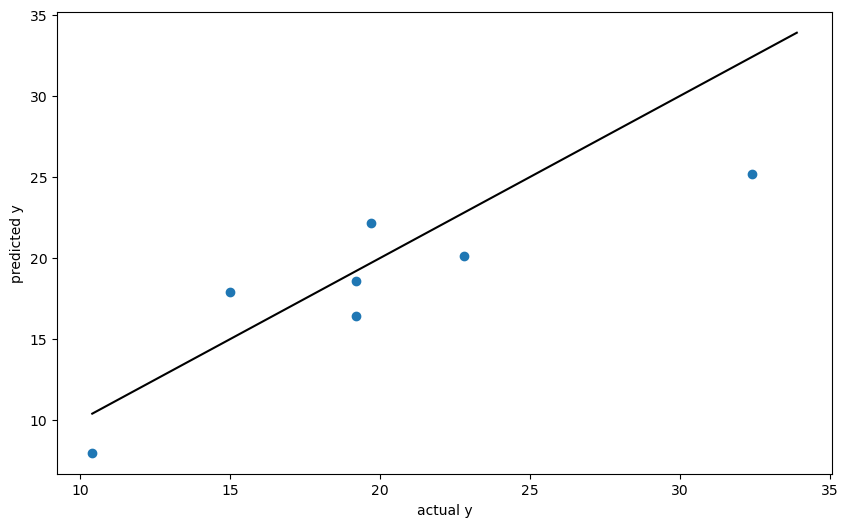

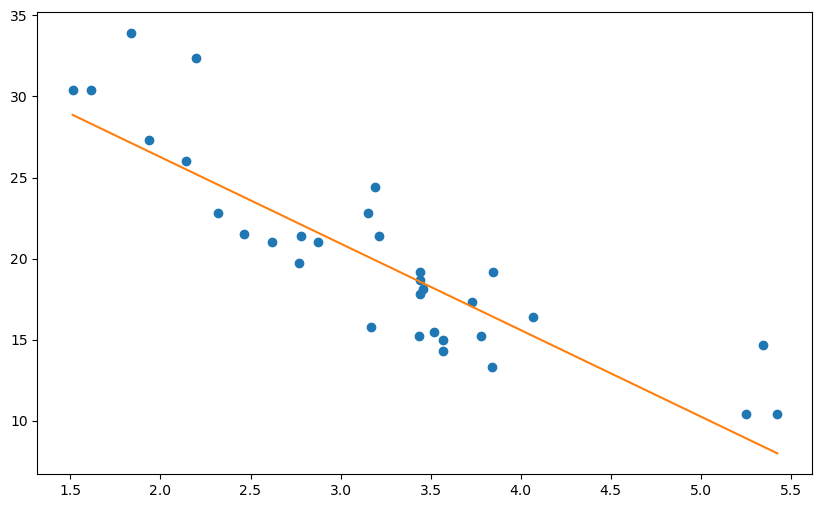

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(dfcars.mpg), np.max(dfcars.mpg), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("actual y")
ax.set_ylabel("predicted y")

fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(dfcars.wt, dfcars.mpg, 'o')
xgrid = np.linspace(np.min(dfcars.wt), np.max(dfcars.wt), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))

## Polynomial Regression, and Cab Data

Polynomial regression uses a **linear model** to estimate a **non-linear function** (i.e., a function with polynomial terms). For example:

$y = \beta_0 + \beta_1x_i + \beta_1x_i^{2}$

It is a linear model because we are still solving a linear equation (the _linear_ aspect refers to the beta coefficients).

In [35]:
# read in the data, break into train and test
cab_df = pd.read_csv("cabs.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [36]:
cab_df.shape

(1250, 2)

In [37]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60 # transforms it to being hour-based
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60 # hour-based
y_test = test_data['PickupCount'].values

def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # optionally use the passed-in transformer
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    # make the prediction at each x value
    prediction = cur_model.predict(dm)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

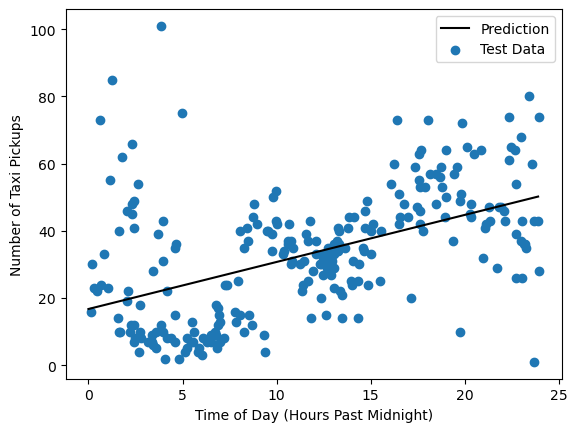

In [38]:
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [39]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. The above code uses `sklearn`. As more practice, and to help you stay versed in both libraries, perform the same task (fit a linear regression line) using `statsmodels` and report the $r^2$ score. Is it the same value as what sklearn reports, and is this the expected behavior?

In [40]:
train_data_x = sm.add_constant(X_train)
test_data_y= sm.add_constant(X_test)

OLSModel = OLS(train_data['PickupCount'].values, train_data_x).fit()

ols_predicted_pickups_test = OLSModel.predict(test_data_y)
r2_score_test = r2_score(test_data[['PickupCount']].values, ols_predicted_pickups_test)
print(r2_score_test)

0.240661535615741


We can see that there's still a lot of variation in cab pickups that's not being captured by a linear fit. Further, the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. This is a bad property, and it's the conseqeuence of having a straight line with a non-zero slope. However, we can add columns to our data for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a curvy polynomial line to hopefully fit the data better.

We'll be using ``sklearn``'s `PolynomialFeatures()` function to take some of the tedium out of building the expanded input data. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$, it will directly return a new copy of the data in this format!

In [41]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
expanded_train = transformer_3.fit_transform(X_train) # TRANSFORMS it to polynomial features
pd.DataFrame(expanded_train).describe() # notice that the columns now contain x, x^2, x^3 values

,0,1,2
count,1000.000000,1000.000000,1000.000000
mean,11.717217,182.833724,3234.000239
std,6.751751,167.225711,3801.801966
min,0.066667,0.004444,0.000296
25%,6.100000,37.210833,226.996222
50%,11.375000,129.390694,1471.820729
75%,17.437500,304.066458,5302.160684
max,23.966667,574.401111,13766.479963


A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a _'transformer'_ in sklearn. We'll be using several transformers that learn a transformation on the training data, and then we will apply those transformations on future data. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above with ``.fit_transform()`.
- You rarely want to `include_bias` (a column of all 1's), since _**sklearn**_ will add it automatically. Remember, when using _**statsmodels,**_ you can just `.add_constant()` right before you fit the data.
- If you want polynomial features for a several different variables (i.e., multinomial regression), you should call `.fit_transform()` separately on each column and append all the results to a copy of the data (unless you also want interaction terms between the newly-created features). See `np.concatenate()` for joining arrays.

fitting expanded_train: [[6.73333333e+00 4.53377778e+01 3.05274370e+02]
 [2.18333333e+00 4.76694444e+00 1.04078287e+01]
 [1.41666667e+00 2.00694444e+00 2.84317130e+00]
 ...
 [1.96666667e+01 3.86777778e+02 7.60662963e+03]
 [1.17333333e+01 1.37671111e+02 1.61534104e+03]
 [1.42000000e+01 2.01640000e+02 2.86328800e+03]]


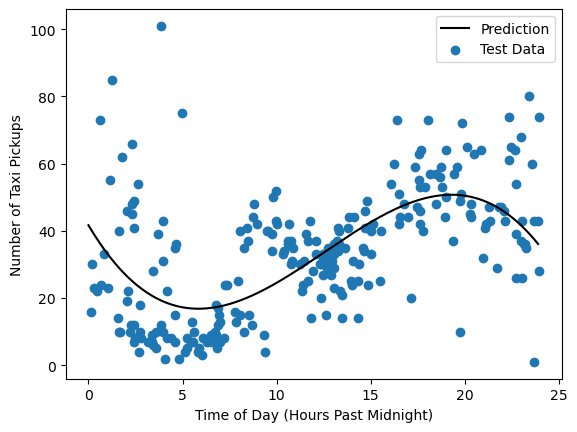

In [42]:
fitted_cab_model3 = LinearRegression().fit(expanded_train, y_train)
print("fitting expanded_train:", expanded_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [43]:
# ANSWER 1
expanded_test = transformer_3.fit_transform(X_test)
print("R^2:", fitted_cab_model3.score(expanded_test, y_test))

R^2: 0.3341251257077904


In [44]:
# ANSWER 2: yes, the polynomial model improves on the purely linear model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


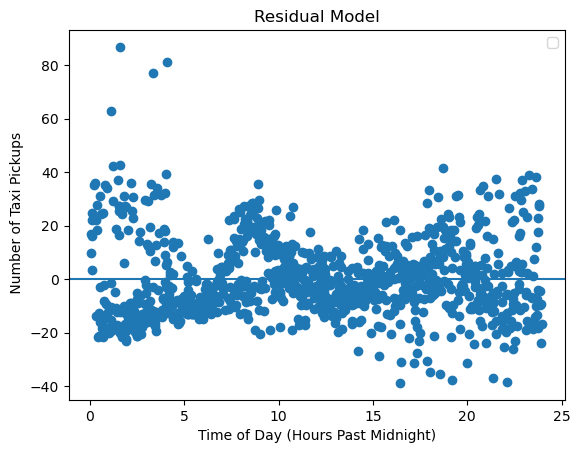

In [45]:
# ANSWER 3 
x_matrix = transformer_3.fit_transform(X_train)

output = fitted_cab_model3.predict(x_matrix)
residual = y_train - output
plt.scatter(X_train, residual)
plt.axhline()

plt.title("Residual Model")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.ylabel(" Number of Taxi Pickups")
plt.legend()

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

### Scaling Features
When using polynomials, we are explicitly trying to use the higher-order values for a given feature. However, sometimes these polynomial features can take on values that are drastically large, making it difficult for the system to learn an appropriate bias weight due to its large values and potentially large variance. To counter this, sometimes one may be interested in scaling the values for a given feature.

For our ongoing taxi-pickup example, using polynomial features improved our model. If we wished to scale the features, we could use `sklearn`'s StandardScaler() function:

In [46]:
# SCALES THE EXPANDED/POLY TRANSFORMED DATA
# we don't need to convert to a pandas dataframe, but it can be useful for scaling select columns
train_copy = pd.DataFrame(expanded_train.copy())
test_copy = pd.DataFrame(expanded_test.copy())

# Fit the scaler on the training data
scaler = StandardScaler().fit(train_copy)

# Scale both the test and training data. 
train_scaled = scaler.transform(expanded_train)
test_scaled = scaler.transform(expanded_test)

# we could optionally run a new regression model on this scaled data
fitted_scaled_cab = LinearRegression().fit(train_scaled, y_train)
fitted_scaled_cab.score(test_scaled, y_test)

0.3341251257077831

<hr style="height:3px">

## Multiple regression and exploring the Football (aka soccer) data
Let's move on to a different dataset! The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by https://www.transfermarkt.us.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on www.transfermarkt.us.on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 1: Import and verification and grouping

In [47]:
league_df = pd.read_csv("league_data.txt")
print(league_df.dtypes)

# QUESTION: what would you guess is the mean age? mean salary?
league_df.head() # turns out, it's a lot

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [48]:
league_df.shape

(461, 17)

In [49]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

1. Use the `train_test_split()` function, while (a) ensuring the test size is 20% of the data, and; (2) using 'stratify' argument to split the data (look up documentation online), keeping equal representation of each region. This doesn't work by default, correct? What is the issue?
2. Deal with the issue you encountered above. Hint: you may find numpy's `.isnan()` and panda's `.dropna()` functions useful!
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

In [50]:
try:
    
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])
except:
    
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])

Uh oh, 1 lines missing data! Dropping them


In [51]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [52]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,27.673077,1130.0,218
CB,8.983582,317.0,178
CF,14.092391,811.0,224
CM,9.009804,416.0,225
DM,12.133333,444.0,131
GK,8.385938,437.5,149
LB,8.629630,380.0,177
LM,4.000000,279.5,99
LW,14.324194,467.0,264


In [53]:
train_data.position.unique()

array(['CB', 'LW', 'CF', 'DM', 'CM', 'RB', 'LB', 'AM', 'RW', 'GK', 'LM',
       'SS', 'RM'], dtype=object)

In [54]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           13.535714   584.000000   65.714286
         CB            4.804082   293.755102   47.469388
         CF            7.698276   776.448276   55.241379
         CM            5.855263   352.552632   38.000000
         DM            7.315789   363.526316   45.736842
         GK            5.039474   416.526316   61.684211
         LB            5.500000   254.333333   52.888889
         LM            4.000000   330.500000   54.166667
         LW            6.214286   349.761905   47.476190
         RB            4.647727   258.272727   51.818182
         RM            4.333333   280.333333    1.666667
         RW            7.358696   502.304348   46.347826
         SS            4.625000   627.250000   13.750000
1        AM           44.166667  2721.166667  155.000000
         CB           20.361111   980.777778   68.555556
         CF           25.000000  2246.764706   79.823529
         CM           18.230769  1534.615385   70.230769
         DM           20.454545  1256.181818   64.090909
         GK           13.276923   782.307692   65.923077
         LB           14.888889   878.222222   64.555556
         LW           31.355000  2378.800000  122.600000
         RB           15.642857   905.428571   75.428571
         RM           18.000000  2537.000000  105.000000
         RW           28.000000  1369.400000   85.200000

<div class="exercise"><b>Exercise</b></div>

**Question**:
1. Notice that the `.groupby()` function above takes a list of two column names. Does the order matter? What happens if we switch the two so that 'position' is listed before 'big_club'?

In [55]:
# your code here
train_data.groupby(['position', 'big_club']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
position big_club                                       
AM       0            13.535714   584.000000   65.714286
         1            44.166667  2721.166667  155.000000
CB       0             4.804082   293.755102   47.469388
         1            20.361111   980.777778   68.555556
CF       0             7.698276   776.448276   55.241379
         1            25.000000  2246.764706   79.823529
CM       0             5.855263   352.552632   38.000000
         1            18.230769  1534.615385   70.230769
DM       0             7.315789   363.526316   45.736842
         1            20.454545  1256.181818   64.090909
GK       0             5.039474   416.526316   61.684211
         1            13.276923   782.307692   65.923077
LB       0             5.500000   254.333333   52.888889
         1            14.888889   878.222222   64.555556
LM       0             4.000000   330.500000   54.166667
LW       0             6.214286   349.761905   47.476190
         1            31.355000  2378.800000  122.600000
RB       0             4.647727   258.272727   51.818182
         1            15.642857   905.428571   75.428571
RM       0             4.333333   280.333333    1.666667
         1            18.000000  2537.000000  105.000000
RW       0             7.358696   502.304348   46.347826
         1            28.000000  1369.400000   85.200000
SS       0             4.625000   627.250000   13.750000

<hr style="height:3px">

## Part 2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football (soccer) data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

**Questions**:
1. Build the data and fit this model to it. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
3. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [56]:
# Q1: we'll do most of it for you ...
y_train = train_data['market_value']
y_test = test_data['market_value']
def build_football_data(df):
    x_matrix = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    x_matrix['log_views'] = np.log2(df['page_views'])
    
    # CREATES THE AGE SQUARED COLUMN
    x_matrix['age_squared'] = df['age']**2
    
    # OPTIONALLY WRITE CODE to adjust the ordering of the columns, just so that it corresponds with the equation above
    x_matrix = x_matrix[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    # add a constant
    x_matrix = sm.add_constant(x_matrix)
    
    return x_matrix

# use build_football_data() to transform both the train_data and test_data
train_transformed = build_football_data(train_data)
test_transformed = build_football_data(test_data)

fitted_model_1 = OLS(endog= y_train, exog=train_transformed, hasconst=True).fit()
fitted_model_1.summary()

# WRITE CODE TO RUN r2_score(), then answer the above question about the overall goodness of the model
r2_score(y_test, fitted_model_1.predict(test_transformed))

# The model is reasonably good. We're capturing about 64%-69% of the variation in market values,
# and the test set confirms that we're not overfitting too badly.

0.5877414423756371

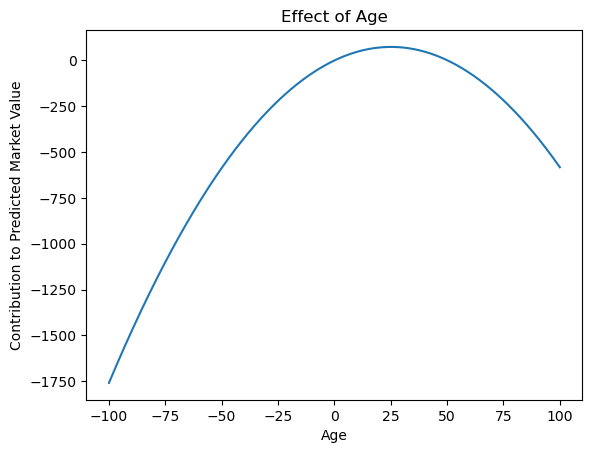

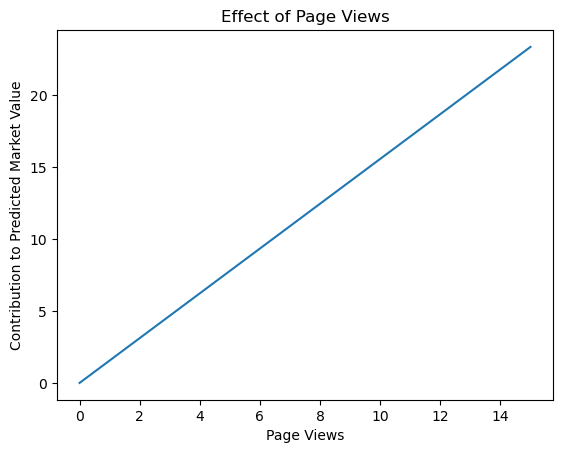

In [57]:
# Q2: let's use the age coefficients to show the effect of age has on one's market value;
# we can get the age and age^2 coefficients via:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

# let's set our x-axis (corresponding to age) to be a wide range from -100 to 100, 
# just to see a grand picture of the function
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2

# WRITE CODE TO PLOT x_vals vs y_vals
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

# Q2A: WHAT HAPPENS IF WE USED ONLY AGE (not AGE^2) in our model (what's the r2?); make the same plot of age vs market value
# Q2B: WHAT HAPPENS IF WE USED ONLY AGE^2 (not age) in our model (what's the r2?); make the same plot of age^2 vs market value
# Q2C: PLOT page views vs market value

# SOLUTION
page_view_coef = fitted_model_1.params.log_views
x_vals = np.linspace(0,15)
y_vals = page_view_coef*x_vals
plt.plot(x_vals, y_vals)
plt.title("Effect of Page Views")
plt.xlabel("Page Views")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

# 3- Linear regression on non-experimental data can't determine causation, so we can't prove that
# a given relationship runs in the direction we might think. For instance, doing whatever it
# takes to get more page views probably doesn't meaningfully increase market value; it's likely
# the causation runs in the other direction and great players get more views. Even so, we can use
# page views to help us tell who is a great player and thus likely to be paid well.

<hr style='height:3px'>

### Part 3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is probably between -0.5 to -1 (depending on your run).

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [58]:
train_design_recoded = pd.get_dummies(train_transformed, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_transformed, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
194,1.0,88,32,1024,9.546894,0,0,0,1,0
92,1.0,224,26,676,12.043027,0,1,0,0,0
316,1.0,62,28,784,9.771489,0,0,0,0,0
73,1.0,0,28,784,7.672425,0,0,0,0,0
312,1.0,80,25,625,8.894818,0,0,1,0,0


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model on the new, recoded data, then interpret the coefficient of `position_cat_2`.


In [59]:
### SOLUTION:
resu = OLS(y_train, train_design_recoded).fit()
resu.summary()
print("r2:", r2_score(y_test, resu.predict(test_design_recoded)))
print("position_cat_2 coef:", resu.params.position_cat_2)
train_design_recoded.shape, y_train.shape

r2: 0.5885379105995048
position_cat_2 coef: -1.20404490686666


((368, 10), (368,))

**SOLUTION:**
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.

## A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of what predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [60]:
set() ^ set([1,2,3])

{1, 2, 3}

In [61]:
set([1]) ^ set([1,2,3])

{2, 3}

In [62]:
set([1, 2]) ^ set([1,2,3])

{3}

Outline a step-forwards algorithm which uses this idea

**SOLUTION:**

Start with no predictors in a set, `selected_predictors`. Then the "xor" will give the set of all predictors. Go through them 1-by -1, seeing which has the highest score/ OR lowestaic/bic. Add this predictor to the `selected_predictors`.

Now repeat. The xor will eliminate this predictor from the remaining predictors. In the next iteration we will pick the next predictor which when combined with the first one gibes the lowest aic/bic of all 2-predictor models.

We repeat. We finally chose the best bic model from the 1 -predictor models, 2-predictor models, 3-predictor models and so on...

## BONUS EXERCISE: (This part is optional and for your practice. This won't be evaluated)
We have provided a spreadsheet of Boston housing prices (boston_housing_train.csv). The 14 columns are as follows:
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per \$10,000
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in $1000s We can see that the input attributes have a mixture of units

There are 450 observations.
<div class="exercise"><b>Exercise</b></div>

Using the above file, try your best to predict **housing prices. (the 14th column)** We have provided a test set `data/boston_housing_test.csv` but refrain from looking at the file or evaluating on it until you have finalized and trained a model.
1. Load in the data. It is tab-delimited. Quickly look at a summary of the data to familiarize yourself with it and ensure nothing is too egregious.
2. Use a previously-discussed function to automatically partition the data into a training and validation (aka development) set. It is up to you to choose how large these two portions should be.
3. Train a basic model on just a subset of the features. What is the performance on the validation set?
4. Train a basic model on all of the features. What is the performance on the validation set?
5. Toy with the model until you feel your results are reasonably good.
6. Perform cross-validation with said model, and measure the average performance. Are the results what you expected? Were the average results better or worse than that from your original 1 validation set?
7. Experiment with other models, and for each, perform 10-fold cross-validation. Which model yields the best average performance? Select this as your final model.
8. Use this model to evaulate your performance on the testing set. What is your performance (MSE)? Is this what you expected?